In [1]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import collections

In [2]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

from subrl.utils.environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from subrl.utils.visualization import Visu

d:\anaconda-python-3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
workspace = "subrl"

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 30, "y": 30},
        "horizon": 80,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "single_room",
        "num": 1,
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 50,
        "lr": 0.01
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 500
    },
    "visu": {
        "wb": "online",
        "a": 1
    }
}

print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(params["env"]["num"])



epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()


{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 30, 'y': 30}, 'horizon': 80, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'single_room', 'num': 1}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 50, 'lr': 0.01}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 500}, 'visu': {'wb': 'online', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001, 18.4999, 18.5001, 19.4999, 19.5001, 20.499

In [4]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)
    
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [11]:
lr = 2e-3
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
state_dim = H-1
action_dim = 5


In [12]:
def train():
    replay_buffer = ReplayBuffer(buffer_size)
    agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                target_update, device)
    params["common"]["batch_size"]=1      #采样的batch大小
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                mat_state = []
                mat_return = []
                env.initialize()
                mat_state.append(env.state)
                init_state = env.state
                for h_iter in range(H-1):
                    batch_state = append_state(mat_state, H-1)

                    actions = [agent.take_action(np.array(batch_state))]

                    env.step(h_iter, actions)

                    mat_state.append(env.state)  # s+1
                    mat_return.append(env.weighted_traj_return(mat_state, type = params["alg"]["type"]))
                    if h_iter == 0:
                        reward = mat_return[-1]
                    else:
                        reward = mat_return[-1]-mat_return[-2]

                    if h_iter == H-2:
                        next_state = batch_state
                        done = 1
                    else:
                        next_state = append_state(mat_state, H-1)
                        done = 0

                    for j in range(params["common"]["batch_size"]):
                        replay_buffer.add(batch_state[j],actions[j],reward[j],next_state[j],done)

                    # 当buffer数据的数量超过一定值后,才进行Q网络训练
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)

                return_list.append(mat_return[-1].float().mean())

                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return agent        

In [13]:
min_return = []
max_return = []
mean_return = []
median_return = []
for iter in range(10):
    agent = train()
    params["common"]["batch_size"]=3000
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, H-1)
        Q_value = agent.q_net(batch_state.to(device))
        probs = F.softmax(Q_value, dim=1)  # 使用softmax将Q值转换为概率分布
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample().cpu()
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    returns = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float()
    min_return.append(returns.min())
    max_return.append(returns.max())
    mean_return.append(returns.mean())
    median_return.append(returns.median())
mean_min_return = np.mean(min_return)
std_min_return = np.std(min_return)
mean_max_return = np.mean(max_return)
std_max_return = np.std(max_return)
mean_mean_return = np.mean(mean_return)
std_mean_return = np.std(mean_return)
mean_median_return = np.mean(median_return)
std_median_return = np.std(median_return)
print(f"min: {mean_min_return:.2f}±{std_min_return:.2f}, max: {mean_max_return:.2f}±{std_max_return:.2f}, mean: {mean_mean_return:.2f}±{std_mean_return:.2f}, median: {mean_median_return:.2f}±{std_median_return:.2f}")

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\ZHY\AppData\Local\Temp\ipykernel_30324\3168535422.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  actions = [agent.take_action(np.array(batch_state))]
Iteration 9: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s, episode=200, return=56.600]


min: 47.50±23.79, max: 106.50±24.61, mean: 77.42±23.58, median: 77.90±24.23


In [8]:
params["common"]["batch_size"]=1
mat_state = []
mat_return = []
env.initialize()
mat_state.append(env.state)
init_state = env.state
for h_iter in range(H-1):
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        batch_state = mat_state[-1].reshape(-1, 1).float()
        # append time index to the state
        batch_state = torch.cat(
            [batch_state, h_iter*torch.ones_like(batch_state)], 1)
    else:
        batch_state = append_state(mat_state, H-1)
    actions = [agent.take_action(np.array(batch_state))]
    env.step(h_iter, actions)
    mat_state.append(env.state)  # s+1
env.weighted_traj_return(mat_state, type = params["alg"]["type"])

/var/folders/59/76h52s611154cw1jnz1dgz5r0000gn/T/ipykernel_86820/2279627388.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  actions = [agent.take_action(np.array(batch_state))]


tensor([50])

In [9]:
def create_path_with_timesteps(states):
    """
    从轨迹数据创建带时间步的路径
    """
    # 将状态转换为带时间步的格式
    path_with_time = [(t, state.item()) for t, state in enumerate(states)]
    return path_with_time
path = create_path_with_timesteps(mat_state)
print(path)

[(0, 34), (1, 64), (2, 34), (3, 4), (4, 4), (5, 3), (6, 2), (7, 1), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 1), (53, 2), (54, 3), (55, 3), (56, 4), (57, 5), (58, 5), (59, 6), (60, 36), (61, 66), (62, 96), (63, 126), (64, 127), (65, 128), (66, 129), (67, 129), (68, 129), (69, 129), (70, 129), (71, 129), (72, 130), (73, 131), (74, 132), (75, 133), (76, 163), (77, 193), (78, 223), (79, 253)]


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001, 18.4999, 18.5001, 19.4999, 19.5001, 20.4999, 20.5001, 21.4999, 21.5001, 22.4999, 22.5001, 23.4999, 23.5001, 24.4999, 24.5001, 25.4999, 25.5001, 26.4999, 26.5001, 27.4999, 27.5001, 28.4999, 28.5001, 29.4999, 29.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001, 18.4999, 18.5001, 19.4999, 19.5001, 20.4999, 20.5001, 21.4999, 21.5001, 22.4999, 22.5001, 23.4999, 23.5001, 24.4999, 24.50

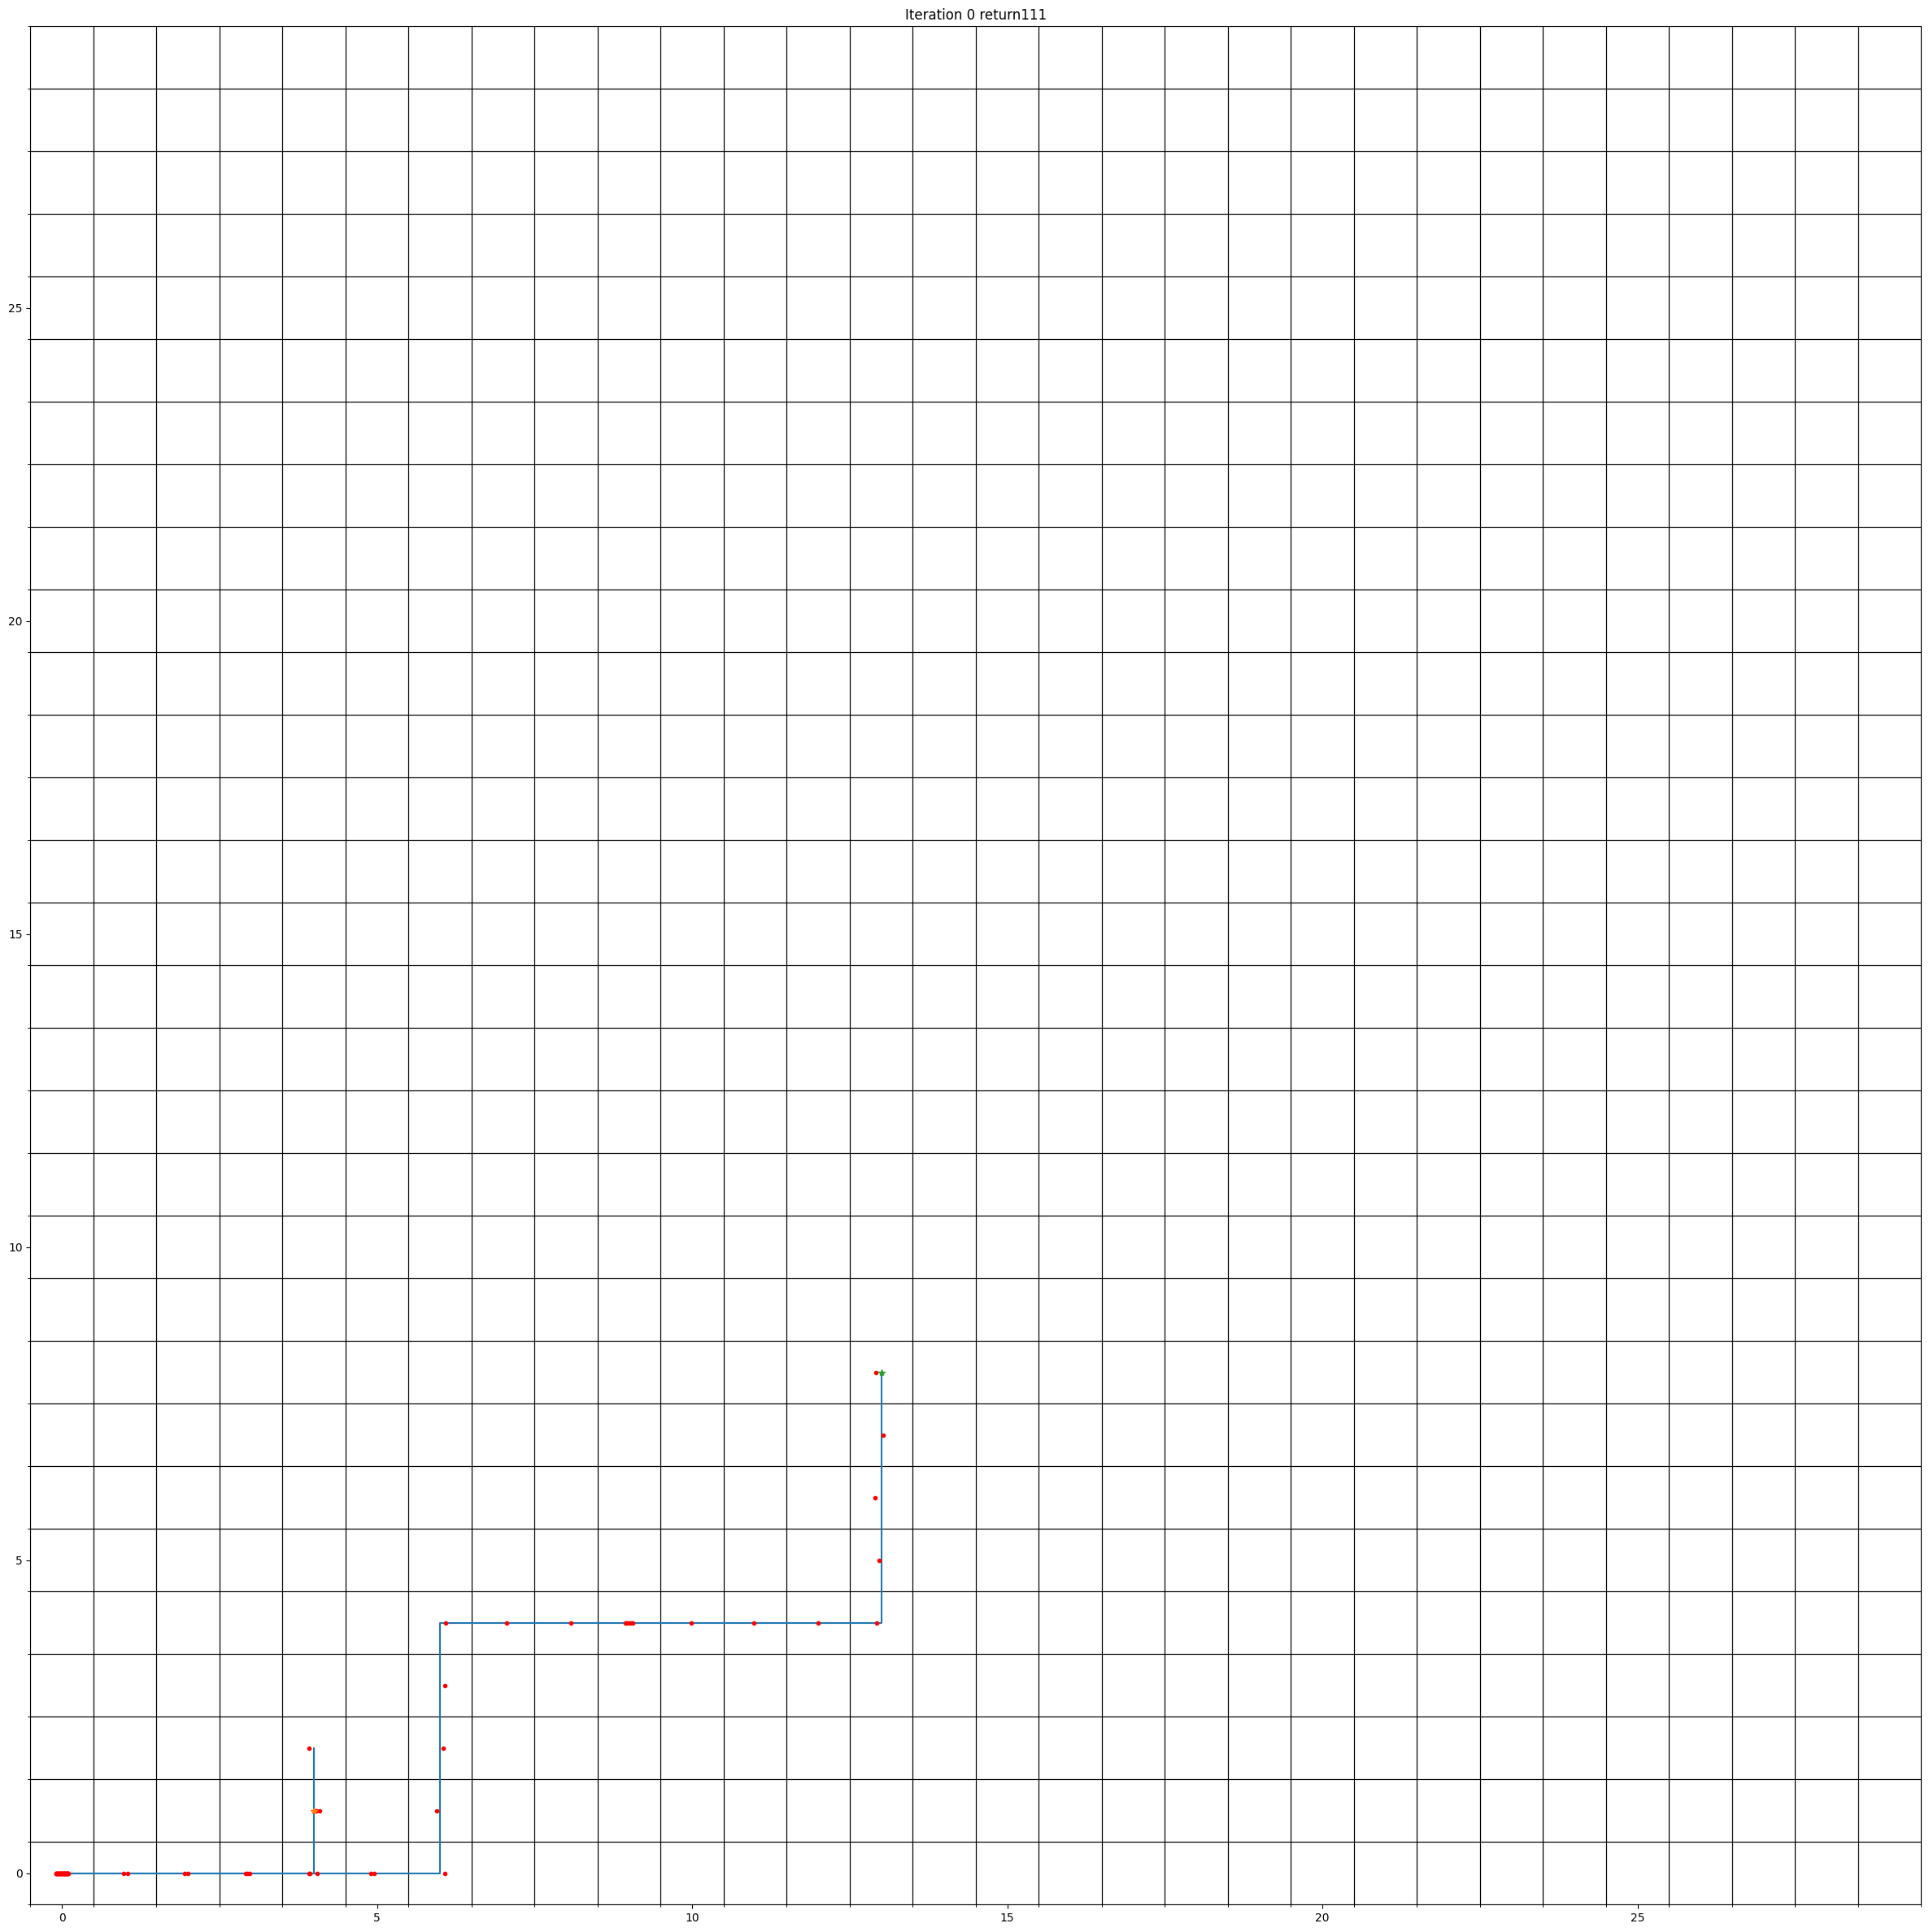

In [10]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
visu = Visu(env_params=params["env"])
visu.visu_path(path,env.Hori_ActionTransitionMatrix)

In [ ]:
params["common"]["batch_size"]=10000
mat_state = []
mat_return = []
env.initialize()
mat_state.append(env.state)
init_state = env.state
for h_iter in range(H-1):
    batch_state = append_state(mat_state, H-1)
    Q_value = agent.q_net(batch_state.to(device))
    probs = F.softmax(Q_value, dim=1)  # 使用softmax将Q值转换为概率分布
    actions_dist = torch.distributions.Categorical(probs)
    actions = actions_dist.sample()
    env.step(h_iter, actions)
    mat_state.append(env.state)  # s+1
min_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().min()
max_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().max()
mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
mean_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
median_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().median()
print(f"DQN agent's return: {mat_return}, min: {min_return}, max: {max_return}, mean: {mean_return}, median: {median_return}")

DQN agent's return: 71.65579986572266, min: 14.0, max: 106.0, mean: 71.65579986572266, median: 78.0


In [ ]:
min_return = []
max_return = []
mean_return = []
median_return = []
for iter in range(10):
    params["common"]["batch_size"]=1000
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, H-1)
        Q_value = agent.q_net(batch_state.to(device))
        probs = F.softmax(Q_value, dim=1)  # 使用softmax将Q值转换为概率分布
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    returns = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float()
    min_return.append(returns.min())
    max_return.append(returns.max())
    mean_return.append(returns.mean())
    median_return.append(returns.median())
mean_min_return = np.mean(min_return)
std_min_return = np.std(min_return)
mean_max_return = np.mean(max_return)
std_max_return = np.std(max_return)
mean_mean_return = np.mean(mean_return)
std_mean_return = np.std(mean_return)
mean_median_return = np.mean(median_return)
std_median_return = np.std(median_return)
print(f"min: {mean_min_return:.2f}±{std_min_return:.2f}, max: {mean_max_return:.2f}±{std_max_return:.2f}, mean: {mean_mean_return:.2f}±{std_mean_return:.2f}, median: {mean_median_return:.2f}±{std_median_return:.2f}")

min: 14.80±1.33, max: 106.90±1.37, mean: 71.45±0.17, median: 78.00±0.00
